# Single label Classifier - AF Detection

Using the dataset provided by the 2020 Physionet Challenge we've developed an Atrial Fibrilation Detector trained to identify AF diagnosed patients from a dataset containing patients with different pathologies like: PAC, RBBB, I-AVB, PVC, LBBB, STD, STE and healthy individuals.

Although data from 12-lead ECG was provided, for this first analysis we've only used the lead 2 data and we've processed the signals in order to create a dataframe consisting of features we believe will help us classify.


In [1]:
import sys
import os
import subprocess
from urllib.parse import urlparse

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from IPython.display import display

from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import mlflow
import mlflow.sklearn

%matplotlib inline
import plotly.express as px
import seaborn as sns

In [2]:
experiment_id = mlflow.set_experiment('features_definitivas')

In [3]:
subprocess.run('rm -rf mlruns/.trash/*', shell=True, check=True)

CompletedProcess(args='rm -rf mlruns/.trash/*', returncode=0)

In [4]:
lead = 'HRV-lead2'
df_raw = pd.read_feather('datasets/phys-raw-lead2-HRV-eda')
df_raw.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_HTI', 'var_P_time', 'var_P_peaks', 'age', 'label'],
      dtype='object')

### Data checks

In [5]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,Non-AF
count,6201.000000,6201.000000
mean,0.168037,0.831963
std,0.373930,0.373930
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


## Split between Train and Validation Datasets

### Training (80%) - Evaluation (20%)

In [6]:
y = df_raw['label'].copy()
X = df_raw.drop('label', axis=1)
X_train, X_test, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, ytrain, yval = train_test_split(X_train, ytrain, test_size=0.2, random_state=42)

ytrain[:5]

2839        AF
3313        AF
1606        AF
736     Non-AF
1455        AF
Name: label, dtype: object

### Label encoding
'AF' as 1 and 'Non-AF' as 0

In [7]:
y_test = label_binarize(ytest, classes=['Non-AF', 'AF'])
y_val = label_binarize(yval, classes=['Non-AF', 'AF'])
y_train = label_binarize(ytrain, classes=['Non-AF', 'AF'])
y_train[:5]

array([[1],
       [1],
       [1],
       [0],
       [1]])

## Evaluation Metrics

This are the evaluation metrics we are actually interested in.

In [8]:
res = pd.DataFrame({'model':[], 'auc cv':[], 'auc val':[], 'f2 val':[]})

## Model Experiments

In [9]:
models = {
        'LDA': LinearDiscriminantAnalysis(),
        'Perceptron': MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3, 3), random_state=42, max_iter=100),
        'Logistic Regression': LogisticRegression(max_iter = 2000, n_jobs = 4, random_state=42),
        'Random Forest': RandomForestClassifier(n_jobs = 4, random_state=42),
        'SVC': SVC(random_state=42),
        'KNNeighbors': KNeighborsClassifier(n_jobs = 4)
}

#scorer = make_scorer(f1_score, pos_label='AF')

In [10]:
for name, model in models.items():
    
    # Model training with cross validation
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=4)
    model.fit(X_train, y_train.ravel())
    
    f2 = fbeta_score(y_val, model.predict(X_val), beta=2)
    roc = roc_auc_score(y_val, model.predict(X_val))
    
    # Save the results to a dataframe
    res = res.append({'model': f"{name}", 'auc cv': scores.mean(), 'auc val': roc, 'f2 val': f2}, ignore_index=True)
    
    # Experiment Tracking
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("model", f"{name}")
        mlflow.log_param("features", "None")
        mlflow.log_param("lead", lead)
        mlflow.log_param("columns", list(X.columns))
        mlflow.log_param("number columns", len(list(X_train.columns)))
        mlflow.log_metric("auc", scores.mean())
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry
        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(model, "model", registered_model_name="AF_Classifier")
        
        else:
            
            mlflow.sklearn.log_model(model, "model")

In [11]:
res.sort_values('auc cv', ascending=False)

,model,auc cv,auc val,f2 val
3,Random Forest,0.982646,0.929979,0.885301
2,Logistic Regression,0.972068,0.908472,0.850000
0,LDA,0.970272,0.927145,0.881720
4,SVC,0.940717,0.500000,0.000000
5,KNNeighbors,0.927043,0.812676,0.687500
1,Perceptron,0.883312,0.500000,0.000000


### Let's try some Scalers

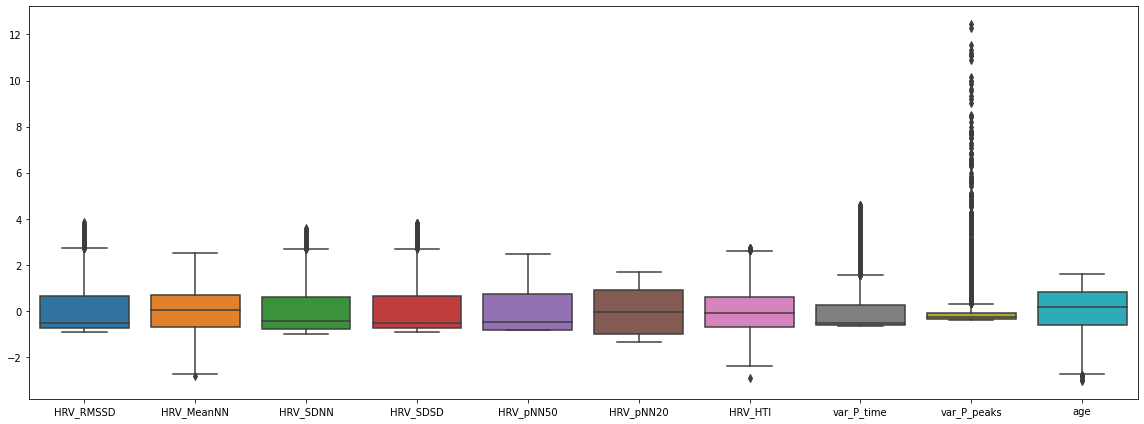

In [12]:
scal = StandardScaler()
df_normal = scal.fit_transform(df_raw.drop('label', axis=1))
cols = df_raw.columns
cols = cols.drop('label')
df_normal = pd.DataFrame(df_normal, columns=cols)

plt.figure(figsize=(16,6))
sns.boxplot(data=df_normal)
plt.tight_layout()
plt.show()

In [13]:
scal = StandardScaler()
xtrain_scal = scal.fit_transform(X_train)
xval_scal = scal.transform(X_val)

In [14]:
for name, model in models.items():
    scores = cross_val_score(model, xtrain_scal, y_train, cv=10, scoring='roc_auc', n_jobs=4)
    model.fit(xtrain_scal, y_train.ravel())
    
    f2 = fbeta_score(y_val, model.predict(xval_scal), beta=2)
    roc = roc_auc_score(y_val, model.predict(xval_scal))
    
    res = res.append({'model': f"{name} Scal", 'auc cv': scores.mean(), 'auc val': roc, 'f2 val': f2}, ignore_index=True)
    
    # Experiment Tracking
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("model", f"{name}")
        mlflow.log_param("features", "Standard Scaler")
        mlflow.log_param("lead", lead)
        mlflow.log_param("columns", list(X.columns))
        mlflow.log_param("number columns", len(list(X_train.columns)))
        mlflow.log_metric("auc", scores.mean())
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(model, "model", registered_model_name="AF_Classifier")
        
        else:
            
            mlflow.sklearn.log_model(model, "model")

/home/tom/anaconda3/envs/af/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [15]:
res.sort_values('auc cv', ascending=False)

,model,auc cv,auc val,f2 val
9,Random Forest Scal,0.982765,0.927216,0.880713
3,Random Forest,0.982646,0.929979,0.885301
10,SVC Scal,0.975965,0.916759,0.863787
7,Perceptron Scal,0.973325,0.885756,0.811870
8,Logistic Regression Scal,0.972348,0.906943,0.847269
2,Logistic Regression,0.972068,0.908472,0.850000
0,LDA,0.970272,0.927145,0.881720
6,LDA Scal,0.970272,0.927145,0.881720
11,KNNeighbors Scal,0.964387,0.910298,0.853524
4,SVC,0.940717,0.500000,0.000000


### Principal Component Analysis

In [16]:
n_comps = 5  # +90% explained variance

pca = PCA(n_components = n_comps)

train_pca = pca.fit_transform(xtrain_scal)

val_pca = pca.transform(xval_scal)

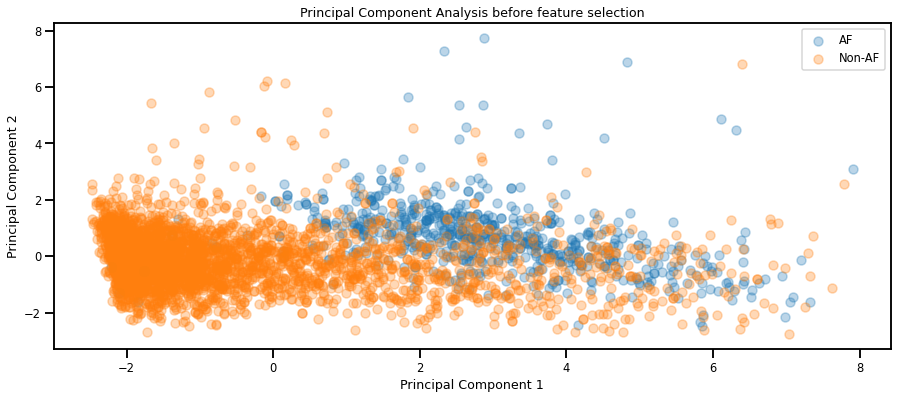

In [17]:
xpca = pd.DataFrame(train_pca)

sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))
plt.scatter(xpca.loc[(y_train == 1).ravel(),0],xpca.loc[(y_train == 1).ravel(),1], alpha = 0.3, label = 'AF')
plt.scatter(xpca.loc[(y_train == 0).ravel(),0],xpca.loc[(y_train == 0).ravel(),1], alpha = 0.3, label = 'Non-AF')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

In [18]:
for name, model in models.items():
    scores = cross_val_score(model, train_pca, y_train, cv=10, scoring='roc_auc', n_jobs=4)
    
    model.fit(train_pca, y_train.ravel())
    
    f2 = fbeta_score(y_val, model.predict(val_pca), beta=2)
    roc = roc_auc_score(y_val, model.predict(val_pca))
    
    res = res.append({'model': f"{name} PCA", 'auc cv': scores.mean(), 'auc val': roc, 'f2 val': f2}, ignore_index=True)
    
    # Experiment Tracking
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("model", f"{name}")
        mlflow.log_param("features", "PCA")
        mlflow.log_param("lead", lead)
        mlflow.log_param("columns", list(X.columns))
        mlflow.log_param("number columns", len(list(X_train.columns)))
        mlflow.log_metric("auc", scores.mean())
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(model, "model", registered_model_name="AF_Classifier")
        
        else:
            
            mlflow.sklearn.log_model(model, "model")

/home/tom/anaconda3/envs/af/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [20]:
res.sort_values('auc cv', ascending=False)

,model,auc cv,auc val,f2 val
9,Random Forest Scal,0.982765,0.927216,0.880713
3,Random Forest,0.982646,0.929979,0.885301
10,SVC Scal,0.975965,0.916759,0.863787
7,Perceptron Scal,0.973325,0.885756,0.811870
8,Logistic Regression Scal,0.972348,0.906943,0.847269
2,Logistic Regression,0.972068,0.908472,0.850000
15,Random Forest PCA,0.971633,0.889431,0.818486
0,LDA,0.970272,0.927145,0.881720
6,LDA Scal,0.970272,0.927145,0.881720
11,KNNeighbors Scal,0.964387,0.910298,0.853524
